# ResOpsMX: attributes
***

**Autor:** Chus Casado Rodríguez<br>
**Fecha:** 05-08-2024<br>

**Introduction:**<br>
This code compares the available attributes for reservoirs in Mexico from different sources: the Mexican Ministry and GRanD.

**To be checked:**<br>
* [ ] At the moment I'm not applying the conditions `MIN_AREA` and `MIN_VOL`.
* [ ] The CONAGUA dataset does not include catchment area.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
from pathlib import Path
import sys
sys.path.append('../../src/')
import geopandas as gpd
from shapely.geometry import Point
import re

import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set_style('ticks')
import yaml

from lisfloodreservoirs.utils.SNCZI import reservoir_attributes, dam_attributes
from lisfloodreservoirs.utils.names import remove_accents, correct_names
from lisfloodreservoirs.utils.utils import filter_reservoirs, remove_duplicates

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Configuration

In [20]:
with open('config_dataset.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

VERSION = cfg['version']

#paths
PATH_RESOPS = Path(cfg['paths']['dataset']['root'])
# PATH_GLOFAS = Path(cfg['paths']['GloFAS']['root'])
PATH_GRAND = Path(cfg['paths']['GRanD'])

# conditions to consider a reservoir in the ResOpsES dataset
MIN_AREA = cfg['conditions'].get('min_area', None) # km2
MIN_VOL = cfg['conditions'].get('min_volume', None) # hm3

# path where results will be saved
PATH_OUT = PATH_RESOPS / VERSION / 'attributes'
PATH_PLOTS = PATH_OUT / 'plots'
PATH_PLOTS.mkdir(parents=True, exist_ok=True)
print(f'Attributes will be saved in {PATH_OUT}')

Attributes will be saved in Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsMX\v1.0\attributes


## CONAGUA

### Dam catalogue

In [3]:
# load reservoirs
conagua = gpd.read_file(PATH_RESOPS / 'raw' / 'attributes' / 'dams.shp')
conagua.columns = conagua.columns.str.upper()
conagua.set_index('KEY', drop=False, inplace=True)
conagua.rename(columns={'NAME': 'RES_NAME'}, inplace=True)
conagua.drop('DAM_ID', axis=1, inplace=True)

# correct names
for col in ['RES_NAME', 'STATE']:
    conagua[col] = [remove_accents(name.split(', ')[0]) for name in conagua[col].str.upper()]

print('CONAGUA')
print('-------')
print('Catalogue')
print('No. reservoirs:\t{0}\nNo. attributes:\t{1}\n'.format(*conagua.shape))

CONAGUA
-------
Catalogue
No. reservoirs:	210
No. attributes:	12



### Dam attributes

I don't know where I got this data. The "DAM_ID" field is not coherent between sources, so I will use the "KEY" as the reservoir identifier. Besides, the key is used to name the time series files.

In [4]:
# load reservoir attributes ¡¡I don't know where I got this data!!
attrs = pd.read_csv(PATH_RESOPS / 'raw' / 'attributes' / 'attributes.csv', index_col='dam_ID', encoding='UTF-8')
rename_cols = {
    'Nombre de presa': 'RES_NAME',
    'Nombre común': 'ALT_NAME',
    'Organismo de cuenca': 'AGENCY',
    'Entidad federativa': 'STATE',
    'NAME Elevación (msnm)': 'NAME_masl',
    'NAME Almacenamiento (hm3)': 'NAME_MCM',
    'NAMO Elevación (msnm)': 'NAMO_masl',
    'NAMO Almacenamiento (hm3)': 'NAMO_MCM'
}
attrs.rename(columns=rename_cols, inplace=True)
attrs.columns = attrs.columns.str.upper()
for col in ['RES_NAME', 'ALT_NAME', 'AGENCY', 'STATE']:
    attrs[col].replace(np.nan, '', inplace=True)
    attrs[col] = [remove_accents(name.split(', ')[0]) for name in attrs[col].str.upper()]
attrs.STATE.replace({'ESTADO DE MEXICO': 'MEXICO'}, inplace=True)

print('Attributes')
print('No. reservoirs:\t{0}\nNo. attributes:\t{1}\n'.format(*attrs.shape))

Attributes
No. reservoirs:	210
No. attributes:	8



In [5]:
# find the key for the reservoirs in 'attrs'
attrs['KEY'] = np.nan
for key in conagua.index:
    name, state = conagua.loc[key, ['RES_NAME', 'STATE']]
    mask_name = attrs.RES_NAME == name
    if mask_name.sum() == 1:
        mask_state = True
    else:
        mask_state = attrs.STATE == state
    attrs.loc[mask_name & mask_state, 'KEY'] = key
if attrs.KEY.isnull().sum() > 0:
    print('WARNING. The key was not found for {0} reservoirs'.format(attrs.KEY.isnull().sum()))
if attrs.index.value_counts().max() > 1:
    print('WARNING. Duplicated keys!!')
attrs.set_index('KEY', inplace=True)

### Combine

In [6]:
# concat tables
new_cols = attrs.columns.difference(conagua.columns)
conagua = pd.concat((conagua, attrs[new_cols]), axis=1).sort_index()
geometry = [Point(xy) for xy in zip(conagua.LON, conagua.LAT)]
conagua = gpd.GeoDataFrame(conagua, geometry=geometry, crs='epsg:4326')

print('Combination')
print('No. reservoirs:\t{0}\nNo. attributes:\t{1}\n'.format(*conagua.shape))

Combination
No. reservoirs:	210
No. attributes:	19



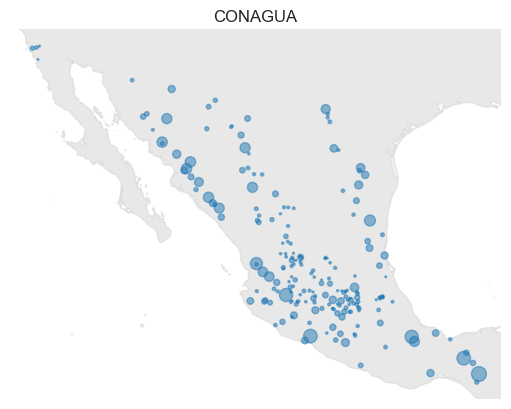

In [7]:
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
conagua.plot(markersize=conagua.NAMO_MCM**.5, alpha=.5, ax=ax)
# fig.legend(frameon=False, bbox_to_anchor=[1, .4, .1, .2])
ax.set_title('CONAGUA')
ax.axis('off');

## GRanD 

GRanD
-----
No. reservoirs:	107
No. attributes:	61

99 out of 107 reservoirs exceed the minimum catchment area of 250 km2 (0 missing values)
107 out of 107 reservoirs exceed the minimum reservoir volume of 10 hm3 (0 missing values)
99 out of 107 reservoirs exceed the minimum catchment area (250 km2) and the minimum reservoir volume (10 hm3)


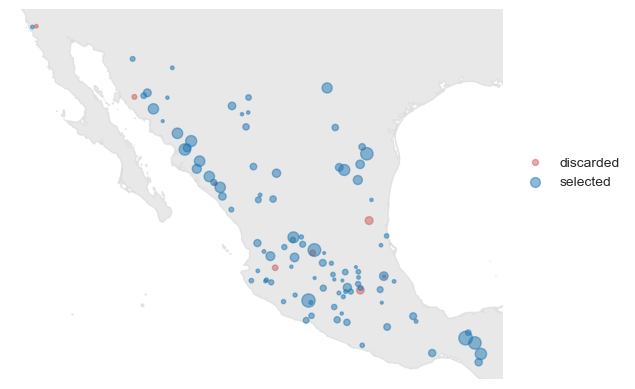

In [8]:
# load shapefile of dams
grand = gpd.read_file(PATH_GRAND / 'GRanD_dams_v1_3.shp')
grand.set_index('GRAND_ID', drop=False, inplace=True)

# filter dams in Spain
grand = grand.loc[grand.COUNTRY == 'Mexico']

# correct names
grand.DAM_NAME = grand.DAM_NAME.str.upper()
grand.RES_NAME = grand.RES_NAME.str.upper()
grand.ADMIN_UNIT = grand.ADMIN_UNIT.str.upper()

# rename columns
grand['LON'] = grand.geometry.x
grand['LAT'] = grand.geometry.y

print('GRanD')
print('-----')
print('No. reservoirs:\t{0}\nNo. attributes:\t{1}\n'.format(*grand.shape))

# select reservoirs based on catchment area and reservoir volume
mask_grand = filter_reservoirs(grand.CATCH_SKM, grand.CAP_MCM, MIN_AREA, MIN_VOL)

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
grand.loc[~mask_grand].plot(markersize=grand.CAP_MCM**.5, c='indianred', alpha=.5, ax=ax, label='discarded')
grand.loc[mask_grand].plot(markersize=grand.CAP_MCM**.5, alpha=.5, ax=ax, label='selected')
fig.legend(frameon=False, bbox_to_anchor=[1, .4, .1, .2])
ax.axis('off');

# apply the selection
# grand = grand.loc[mask_grand]

### Connect CONAGUA and GRanD

In [9]:
# create field for the CONAGUA key
grand['KEY'] = np.nan
for src_col in ['RES_NAME', 'ALT_NAME']:
    for dst_col in ['RES_NAME', 'DAM_NAME', 'ALT_NAME']:
        # find matches
        mask_name = conagua[src_col].isin(grand[dst_col])
        for key in conagua[mask_name].KEY:
            name, state = conagua.loc[key, [src_col, 'STATE']]
            grand.loc[(grand[dst_col] == name) & (grand.ADMIN_UNIT == state), 'KEY'] = key

# check missing values
missing = grand.KEY.isnull().sum()
if missing > 0:
    print(f'{missing} reservoir in CONAGUA are missing in GRanD')    
    grand = grand.loc[grand.KEY.notnull()]
grand.set_index('KEY', drop=False, inplace=True)
print('CONAGUA & GRanD')
print('No. reservoirs:\t{0}\nNo. attributes:\t{1}\n'.format(*grand.shape))

# assign GRAND_ID to the 'conagua' table
keys = set(conagua.KEY).intersection(grand.KEY)
conagua.loc[keys, 'GRAND_ID'] = grand.loc[keys, 'GRAND_ID']
conagua = conagua.loc[conagua.GRAND_ID.notnull()]
conagua['GRAND_ID'] = conagua.GRAND_ID.astype(int)

# set GRAND_ID as index in both data sources
conagua.set_index('GRAND_ID', drop=True, inplace=True)
grand.set_index('GRAND_ID', drop=True, inplace=True)

8 reservoir in CONAGUA are missing in GRanD
CONAGUA & GRanD
No. reservoirs:	99
No. attributes:	62



C:\DEV\Anaconda3\envs\xr\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


### Reservoir use

In [10]:
# rename columns
rename_uses_grand = {'USE_IRRI': 'irrigation',
                     'USE_ELEC': 'hydropower',
                     'USE_SUPP': 'supply',
                     'USE_FCON': 'flood',
                     'USE_RECR': 'recreation',
                     'USE_NAVI': 'navigation',
                     'USE_FISH': 'fish',
                     'USE_PCON': 'pollution',
                     'USE_LIVE': 'livestock',
                     'USE_OTHR': 'other'}
grand.rename(columns=rename_uses_grand, inplace=True)

# replace values in 'MAIN_USE' to be consistent with the columns
grand.MAIN_USE.replace({'Irrigation': 'irrigation',
                        'Hydroelectricity': 'hydropower',
                        'Water supply': 'supply',
                        'Other': 'other',
                        'Recreation': 'recreation',
                        'Flood control': 'flood'},
                       inplace=True)

# convert to boolean
grand_uses = list(rename_uses_grand.values())
grand[grand_uses] = grand[grand_uses].replace({'Main': True, 'Major': True, 'Sec': True, None: False})

# identify single purpose reservoirs
grand['SINGLE_USE'] = False
mask_singleuse = grand[grand_uses].sum(axis=1) == 1
grand.loc[mask_singleuse, 'SINGLE_USE'] = True

**Main use**

In [11]:
mask_singleuse = grand.SINGLE_USE
mask_hdcc = ~grand.index.isnull()

mainuse_singlepurpose = grand.loc[mask_hdcc & mask_singleuse, 'MAIN_USE'].value_counts()
mainuse_multipurpose = grand.loc[mask_hdcc, 'MAIN_USE'].value_counts()
mainuse_summary_grand = pd.concat((mainuse_singlepurpose, mainuse_multipurpose), axis=1)
mainuse_summary_grand.columns = ['singlepurpose', 'multipurpose']
mainuse_summary_grand.sort_values('multipurpose', ascending=False, inplace=True)
del mainuse_singlepurpose, mainuse_multipurpose

**All uses**

In [12]:
alluses_singlepurpose = grand.loc[mask_hdcc & mask_singleuse, grand_uses].sum()
alluses_multipurpose = grand.loc[mask_hdcc, grand_uses].sum()
alluses_summary_grand = pd.concat((alluses_singlepurpose, alluses_multipurpose), axis=1)
alluses_summary_grand.columns = ['singlepurpose', 'multipurpose']
alluses_summary_grand.sort_values('multipurpose', ascending=False, inplace=True)
alluses_summary_grand.dropna(axis=0, how='all', inplace=True)
alluses_summary_grand = alluses_summary_grand[~(alluses_summary_grand == 0).all(axis=1)]
del alluses_singlepurpose, alluses_multipurpose

### Export

In [24]:
# convert boolean fields to 0-1
bool_cols = list(rename_uses_grand.values()) + ['SINGLE_USE']
grand[bool_cols] = grand[bool_cols].astype(bool).astype(int)

# attributes to be included from EFAS
cols_grand = ['DAM_NAME', 'YEAR', 'REM_YEAR',
              'DAM_HGT_M', 'DAM_LEN_M', 'AREA_SKM', 'CAP_MCM', 'DEPTH_M', 'DIS_AVG_LS', 'DOR_PC', 'ELEV_MASL', 'CATCH_SKM',
              'irrigation', 'hydropower', 'supply', 'flood', 'recreation', 'navigation', 'fish', 'pollution', 'livestock', 'other', 'MAIN_USE', 'SINGLE_USE','LAKE_CTRL']

In [25]:
# export as CSV
grand[cols_grand].to_csv(PATH_OUT / 'grand.csv')
#grand.loc[:, cols_grand].to_csv(PATH_OUT / 'attributes_GRanD.csv')

In [23]:
conagua.drop('geometry', axis=1).sort_index().to_csv(PATH_OUT / 'conagua.csv')

***

Below are cells inherited from the original notebook in ResOpsES.

## Comparison of data sets

In [ ]:
# limit `cedex` to the reservoirs that fulfil the conditions
cedex = cedex.loc[mask_cedex]

### Reservoir volume

* CEDEX dams: `'V_MNL'`. This value does not represent total capacity, but the capacity at a normal level. Therefore, the actual reservoir capacity should always be larger than this value.
* CEDEX reservoirs: `'V_total'`, `'V_live'`
* ICOLD: `'Res_Vol'`
* EFAS: `'Vtotal'`
* GRanD: `'CAP_MCM'`

In [ ]:
variable = 'CAP_MCM'

# combine all volume data in a single table
volume = pd.concat((cedex[[variable, 'VOL_MNL']],
                    efas[variable],
                    icold[variable],
                    grand[variable], 
                   ), axis=1)
volume.columns = ['CEDEX', 'CEDEX_MNL', 'EFAS', 'ICOLD', 'GRanD']

print('Number of reservoirs:\t{0}\nNumber of data sets:\t{1}'.format(*volume.shape))

# summarize
volume_summary = pd.concat(((~volume.isnull()).sum(), volume.sum()), axis=1)
volume_summary.columns = ['no_reservoirs', 'total_volume']
volume_summary.sort_values('no_reservoirs', ascending=False, inplace=True)

# plot summary
fig, axes = plt.subplots(ncols=2, figsize=(8.5, 4), sharey=True)
for ax, col in zip(axes, volume_summary):
    ax.barh(volume_summary.index, volume_summary[col], color='lightsteelblue')
    ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    ax.tick_params(axis='y', length=0)
    if ax == axes[0]:
        ax.set(xlabel='no. reservoirs')
    elif ax == axes[1]:
        ax.set(xlabel='total volume (hm3)')
        
plt.savefig(PATH_PLOTS / 'reservoir_volume_barplot.jpg', dpi=300, bbox_inches='tight');

The data in the plots above only represents the reservoirs in the datasets (EFAS, GRanD, ICOLD) that I could match with reservoirs in the HDCC database. The datasets on their own may contain more reservoirs; for instance, ICOLD includes 1066 reservoirs in Spain, but "only" 374 could be matched with the 394 reservoirs in HDCC.

EFAS and GRanD are the two data sets with fewer number of reservoirs. However, the total volume that those reservoirs represent is very close to more comprehensive data sets as ICOLD or CEDEX. Interestingly, the total volume in ICOLD slightly exceeds that in CEDEX. This could be caused by the fact that CEDEX volume does not represent total capacity, but the storage at the normal reservoir level.

In [ ]:
# pair plot
pair_plot = sns.pairplot(volume, corner=True, plot_kws={'alpha': .5})

# reference 1:1 line
nrow, ncol = pair_plot.axes.shape
vmin, vmax = volume.min().min(), volume.max().max()
for i in range(nrow):
    for j in range(ncol):
        if i > j:
            pair_plot.axes[i, j].plot([vmin, vmax], [vmin, vmax],
                                      c='k', lw=1, ls=':', zorder=0)
pair_plot.fig.suptitle('Reservoir volume (hm3)')

plt.savefig(PATH_PLOTS / 'reservoir_volume_pairplot.jpg', dpi=300, bbox_inches='tight');

I assume that CEDEX `CEDEX` is the reference data set, as it is the local data set that probably was used by GRanD and ICOLD to develop their global data sets.

Overall, there's a good agreement between all data sets:
 * ICOLD has a few reservoirs whose storage clearly exceeds the values reported by CEDEX.
 * GRanD reservoir storage shows more deviations compared with CEDEX. This deviations are small in most cases, and both overestimate or underestimate storage.
 * As the majority of reservoirs in EFAS come from GRanD, the analysis is similar to that of GRanD.
 * The live volume in CEDEX reservoirs is obviously smaller than the normal storage in most of the cases. However, there are a couple of errors in which the live volume exceeds the normal volume.

### Reservoir surface area

All reservoir area values are in km2:

* CEDEX dams: `'A_MNL'` in ha. This value does not represent the maximum area, but the surface at a normal level.
* CEDEX reservoirs: `'AREA'`
* ICOLD: `'Res_Area'`
* EFAS: none
* GRanD: `'AREA_SKM'`

In [ ]:
variable = 'AREA_SKM'

# combine all volume data in a single table
area = pd.concat((cedex[[variable, 'AREA_MNL']],
                  icold[variable],
                  #efas[variable],
                  grand[variable], 
                 ), axis=1)
area.columns = ['CEDEX', 'CEDEX_MNL', 'ICOLD', 'GRanD']

print('Number of reservoirs:\t{0}\nNumber of data sets:\t{1}'.format(*area.shape))

# summarize
area_summary = pd.concat(((~area.isnull()).sum(), area.sum()), axis=1)
area_summary.columns = ['no_reservoirs', 'total_area']
area_summary.sort_values('no_reservoirs', ascending=False, inplace=True)

# plot summary
fig, axes = plt.subplots(ncols=2, figsize=(8.5, 4), sharey=True)
for ax, col in zip(axes, area_summary):
    ax.barh(area_summary.index, area_summary[col], color='lightsteelblue')
    ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    ax.tick_params(axis='y', length=0)
    if ax == axes[0]:
        ax.set(xlabel='no. reservoirs')
    elif ax == axes[1]:
        ax.set(xlabel='total area (km²)')
        
plt.savefig(PATH_PLOTS / 'reservoir_area_barplot.jpg', dpi=300, bbox_inches='tight');

The values for ICOD and CEDEX are very similar, both in terms of number of reservoirs and the total reservoir area. As seen for volume, ICOLD has a slightly smaller set of reservoirs than CEDEX, but the total aggregation slightly exceeds CEDEX. Again, this could be caused by CEDEX reporting area/volume at normal reservoir level, not at its maximum level.

GRanD reports reservoir area in approximately half of the reservoirs. The total reservoir area seems to be in a similar proportion.

In [ ]:
# pair plot
pair_plot = sns.pairplot(area, corner=True, plot_kws={'alpha': .5})

# reference 1:1 line
nrow, ncol = pair_plot.axes.shape
amin, amax = area.min().min(), area.max().max()
for i in range(nrow):
    for j in range(ncol):
        if i > j:
            pair_plot.axes[i, j].plot([amin, amax], [amin, amax],
                                      c='k', lw=1, ls=':', zorder=0)
pair_plot.fig.suptitle('Reservoir surface (km²)')

plt.savefig(PATH_PLOTS / 'reservoir_area_pairplot.jpg', dpi=300, bbox_inches='tight');

The pair plots above show that GRanD underestimates reservoir area., and there seems to be a clear trend (even though the spread increases with increasing reservoir size).

ICOLD data agrees appropriately with CEDEX.

### Catchment area

All catchment area values are in km2?

* CEDEX dams: `'catch_area'` in ha. This value does not represent the maximum area, but the surface at a normal level.
* ICOLD: `'Catch_Area'`
* EFAS: none
* GRanD: `'CATCH_SKM'`

In [ ]:
variable = 'CATCH_SKM'

# combine all volume data in a single table
catchment = pd.concat((cedex[variable],
                       efas[variable],
                       icold[variable],
                       grand[variable], 
                      ), axis=1)
catchment.columns = ['CEDEX', 'EFAS', 'ICOLD', 'GRanD']

print('Number of reservoirs:\t{0}\nNumber of data sets:\t{1}'.format(*catchment.shape))

# summarize
catchment_summary = pd.concat(((~catchment.isnull()).sum(), catchment.sum()), axis=1)
catchment_summary.columns = ['no_reservoirs', 'total_area']
catchment_summary.sort_values('no_reservoirs', ascending=False, inplace=True)

# plot summary
fig, axes = plt.subplots(ncols=2, figsize=(8.5, 4), sharey=True)
for ax, col in zip(axes, catchment_summary):
    ax.barh(catchment_summary.index, catchment_summary[col], color='lightsteelblue')
    ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False)
    ax.tick_params(axis='y', length=0)
    if ax == axes[0]:
        ax.set(xlabel='no. reservoirs')
    elif ax == axes[1]:
        ax.set(xlabel='total catchment area (km²)')
        
plt.savefig(PATH_PLOTS / 'reservoir_catchment_barplot.jpg', dpi=300, bbox_inches='tight');

The catchment area value is missing from several reservoirs in CEDEX, which causes that ICOLD is the most comprehensive data set. Even though the number of reservoirs in GRanD that report catchment area is notably smaller, the total catchment area is close to other data sets, meaning that GRanD includes the reservoirs with larger contributing area.

In [ ]:
# pair plot
pair_plot = sns.pairplot(catchment, corner=True, plot_kws={'alpha': .5})

# reference 1:1 line
nrow, ncol = pair_plot.axes.shape
amin, amax = catchment.min().min(), catchment.max().max()
for i in range(nrow):
    for j in range(ncol):
        if i > j:
            pair_plot.axes[i, j].plot([amin, amax], [amin, amax],
                                      c='k', lw=1, ls=':', zorder=0)
pair_plot.fig.suptitle('Catchment area (km²)')
            
plt.savefig(PATH_PLOTS / 'reservoir_catchment_pairplot.jpg', dpi=300, bbox_inches='tight');

There is a considerable scatter in the areas among the smallest catchments. Specifically, GRanD has some rerservoirs which overestimate catchment area compared both with CEDEX and ICOLD. ICOLD, instead, includes catchment areas that differ in both ways (over or underestimate) the area of small catchments compared with CEDEX.

**Test GIS and `cutmaps` catchments**

In [ ]:
# calculate the upstream area for each reservoir catchment
filename = 'upArea_01min.nc'
path_cutmaps = PATH_RESOPSMX / 'ancillary' / 'cutmaps'
cutmaps = pd.Series(index=points.id, dtype=float, name='CATCH_SKM')
cutmaps.index.name = 'SNCZI'
for ID in tqdm(cutmaps.index):
    # load map cut
    data = xr.open_dataset(path_cutmaps / ID / filename)['Band1']
    # calculate catchment area in km²
    cutmaps.loc[ID] = data.max().values / 1e6

# assign values to the "catchment" DataFrame
cutmaps.index = cutmaps.index.astype(int)
catchment.loc[cutmaps.index, 'cutmaps'] = cutmaps.values

In [ ]:
# import watershed polygons derived in GIS
gis = gpd.read_file(PATH_RESOPSMX / 'GIS' / 'Layers' / 'watershed_305.shp')
gis.Name = gis.Name.astype('Int64')
gis.rename(columns={'Name': 'SNCZI', 'Shape_Leng': 'LENG_KM', 'Shape_Area': 'CATCH_SKM'}, inplace=True)
gis.set_index('SNCZI', inplace=True)
gis.drop(['OID_', 'HydroID'], axis=1, inplace=True)

# assign values to the "catchment" DataFrame
catchment.loc[gis.index, 'GIS'] = gis.CATCH_SKM.values

In [ ]:
sns.pairplot(catchment, corner=True, plot_kws={'alpha': .5});

In [ ]:
catchment.loc[[616, 1038, 1290, 1342, 1643, 1840, 1953, 2050]]

In [ ]:
idx = reservoirs.loc[reservoirs.TS == 1].index.difference(watershed.index).tolist()

In [ ]:
reservoirs.loc[idx]

In [ ]:
watershed.boundary.plot()

In [ ]:
# add to the comparative table the area of the polygons derived in GIS
catchment.loc[watershed.index, 'GIS'] = watershed['CATCH_SKM']

In [ ]:
# # create a field reporting the most reliable value of the catchment area
# catchment['CATCH_SKM'] = catchment[['CEDEX', 'ICOLD']].max(axis=1)
# mask = catchment.CATCH_SKM.isnull()
# catchment.loc[mask, 'CATCH_SKM'] = catchment.loc[mask, 'GRanD']

In [ ]:
# create a field reporting the most reliable value of the catchment area
catchment['CATCH_SKM'] = catchment.GRanD
mask = catchment.CATCH_SKM.isnull()
catchment.loc[mask, 'CATCH_SKM'] = catchment.loc[mask, ['CEDEX', 'ICOLD']].min(axis=1)

In [ ]:
error = (catchment.GIS - catchment.CATCH_SKM) / catchment.CATCH_SKM * 100
catchment.loc[error.abs() > 50].sort_index().round(0)

It seems like GRanD is a more reliable source in terms of catchment area, so, when available, I compare against this data set. If not avaible, I compare agains the minimum between CEDEX and ICOLD.

* __Correct in GIS__: 52, 173, 317, 400, 442, 620, 916, 993, 1019, 1062, 1075, 1125, 1285, 1565, 1657, 2083, 2101, 2175, 2261, 2469?, 2561
* __Wrong in GIS__: 616, 1038, 1290, 1342, 1643, 1840, 1953, 2050

Incongruences between CEDEX and ICOLD.

In [ ]:
print(f'{catchment.CEDEX.isnull().sum()} reservoir miss the catchment area in CEDEX')
print(f'{catchment.ICOLD.isnull().sum()} reservoir miss the catchment area in ICOLD')
print(f'{catchment.GRanD.isnull().sum()} reservoir miss the catchment area in GRanD')
print(f'{catchment.GIS.isnull().sum()} reservoir miss the catchment area in GIS')

### Reservoir use

**Main use**

In [ ]:
main_use = {'CEDEX': mainuse_summary_cedex,
            'ICOLD': mainuse_summary_icold,
            'GRanD': mainuse_summary_grand}

fig, axes = plt.subplots(ncols=len(main_use), figsize=(len(main_use) * 4, 4), sharex=True, tight_layout=True)
for ax, (label, df) in zip(axes, main_use.items()):
    ax.barh(df.index, df.multipurpose, color='steelblue', label='multi-purpose')
    ax.barh(df.index, df.singlepurpose, color='lightsteelblue', label='single purpose')
    ax.set(title=label,
           xlabel='no. reservoirs')
    ax.tick_params(axis='y', length=0)
    ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False);
fig.suptitle('Main reservoir use')
fig.legend(*ax.get_legend_handles_labels(), loc=5, frameon=False, bbox_to_anchor=[1.02, .4, .1, .2]);

plt.savefig(PATH_PLOTS / 'reservoir_main_use.jpg', dpi=300, bbox_inches='tight');

The definition of the main use of a reservoir is ambiguous. Is it the use that requires larger water volume? Is it a design decision? 

The ambiguity is clear in the plot above. Even though the two most common main uses (supply and hydropower) coincide in CEDEX and ICOLD, the figures differ notably. These two data sets assign different importance to flood and irrigation. On the contrary, GRanD identifies irrigation as the main reservoir use in Spain, followed by hydropower and supply; flood control has no importance in this data set.

**All uses**

In [ ]:
all_uses = {'CEDEX': alluses_summary_cedex,
            'ICOLD': alluses_summary_icold,
            'GRanD': alluses_summary_grand}

fig, axes = plt.subplots(ncols=len(all_uses), figsize=(len(all_uses) * 4, 4), sharex=True, tight_layout=True)
for ax, (label, df) in zip(axes, all_uses.items()):
    ax.barh(df.index, df.multipurpose, color='steelblue', label='multi-purpose')
    ax.barh(df.index, df.singlepurpose, color='lightsteelblue', label='single purpose')
    ax.set(title=label,
           xlabel='no. reservoirs')
    ax.tick_params(axis='y', length=0)
    ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False);
fig.suptitle('All reservoir uses')
fig.legend(*ax.get_legend_handles_labels(), loc=5, frameon=False, bbox_to_anchor=[1.02, .4, .1, .2]);

plt.savefig(PATH_PLOTS / 'reservoir_all_uses.jpg', dpi=300, bbox_inches='tight');

The difference between the three data sets remains when looking at all the reservoir uses. ICOLD and GRanD identify hydropower and irrigation as the two most common uses, even though the order differs between them two. CEDEX, instead, considers water supply as the main use (3rd in ICOLD and GRanD), and limits hydropower and irrigation to the 3rd and 4th rank. It's remarkable that flood control is the second most common use in CEDEX, but it has a residual value in both ICOLD and GRanD.

## Conclusion

ICOLD seems to be the best data set to extract the reservoir static attributes. In the specific case of Spain, the Spanish National Inventory of Reservoirs and Dams (CEDEX) is more comprehensive, both in terms of number of reservoirs and the number of attributes. However, since this is only an exercise that must be extrapolated continentally/globally, we need to use a global data set like ICOLD or GRanD. The comparison of these two global data sets against CEDEX shows that the figures in ICOLD are closer to the reference. On top of that, I could match 374 reservoirs between the observed time series and ICOLD, and only 225 with GRanD, so using ICOLD increases notably the sample of reservoirs.

The drawback of using ICOLD is that the data can not be open.

In [ ]:
# export shapefile of reservoirs
hdcc['lon_orig'] = hdcc.geometry.x
hdcc['lat_orig'] = hdcc.geometry.y
hdcc[['lon_lisf', 'lat_lisf']] = np.nan

# hdcc.to_file(PATH_RESOPSMX / 'GIS' / 'reservoirs_ResOpsES.shp')

### Reservoirs with time series

**Anuario de Aforos**

Import shapefile of reservoirs in the Hydrological Data Colection Center (HDCC) database.

In [ ]:
path_cedex = PATH_RESOPSS / 'CEDEX' / 'processed' / 'reservoirs'
reservoirs_AA = gpd.read_file(path_cedex / 'attributes' / 'GIS' / 'reservoirs.shp')
reservoirs_AA.ref_ceh = reservoirs_AA.ref_ceh.astype('Int64')
reservoirs_AA['source'] = 'CEDEX'
reservoirs_AA.rename(columns={'nombre': 'name', 'ref_ceh': 'ID'}, inplace=True)
reservoirs_AA['SNCZI'] = reservoirs_AA['SNCZI'].replace(0, np.nan).astype('Int64')
reservoirs_AA.set_index('SNCZI', drop=True, inplace=True)
reservoirs_AA.sort_index(axis=0, inplace=True)

print('Anuario de Aforos contains {0} reservoirs'.format(reservoirs_AA.shape[0]))
print('{0} reservoirs are not connected to the SNCZI database'.format((reservoirs_AA.index.isnull()).sum()))
# reservoirs_AA.head()

**Agència Catalana de l'Aigua**

I have downloaded reservoir records from the ACA website, but these reservoirs are not yet in HDCC. I will upload here the shapefile of the ACA reservoirs and concatenate it to HDCC.

In [ ]:
# load shapefile and treat the data
reservoirs_aca = gpd.read_file(PATH_RESOPSS / 'ACA' / 'processed' / 'reservoirs' / 'attributes' / 'GIS' / 'reservoirs_ACA.shp')
reservoirs_aca['source'] = 'ACA'
reservoirs_aca.set_index('SNCZI', inplace=True, drop=True)
reservoirs_aca.rename(columns={'ID_ACA': 'ID'}, inplace=True)

print('ACA contains {0} reservoirs'.format(reservoirs_aca.shape[0]))
print('{0} reservoirs are not connected to the SNCZI database'.format((reservoirs_aca.index.isnull()).sum()))
# reservoirs_aca.head()

**Hidrosur**

I have requested reservoir data from Hidrosur. This data is not yet in HDCC, so I will load it here and combine it with the reservoirs in HDCC.

In [ ]:
# load shapefile and treat the data
reservoirs_sur = gpd.read_file(PATH_RESOPSS / 'Hidrosur' / 'processed' / 'reservoirs' / 'attributes' / 'GIS' / 'reservoirs_hidrosur.shp')
reservoirs_sur['source'] = 'Hidrosur'
reservoirs_sur['SNCZI'] = reservoirs_sur['SNCZI'].astype('Int64')
reservoirs_sur.set_index('SNCZI', drop=True, inplace=True)

print('Hidrosur contains {0} reservoirs'.format(reservoirs_sur.shape[0]))
print('{0} reservoirs are not connected to the SNCZI database'.format((reservoirs_sur.index.isnull()).sum()))
# reservoirs_sur.head()

**Merge all**

<font color='indianred'>I remove the reservoirs without SNCZI code.</font>

In [ ]:
cols = ['ID', 'name', 'source', 'geometry']
hdcc = pd.concat((reservoirs_AA[cols], reservoirs_aca[cols], reservoirs_sur[cols]), axis=0)
hdcc.index = hdcc.index.astype('Int64')
# remove one of the instances of the Siurana reservoir (included both in Anuario and ACA)
# I remove the instance in the ACA (`ID == 'E18')
hdcc = hdcc.loc[hdcc.ID != 'E18']
hdcc.name = hdcc.name.str.replace(r'(.+), (.+)', r'\2 \1', regex=True)
# hdcc.name = hdcc.name.apply(unidecode.unidecode)
hdcc.name = [remove_accents(name) for name in hdcc.name]

print('Anuario + ACA + Hidrosur:\t{0} reservoirs'.format(hdcc.shape[0]))
print('{0} reservoirs are not connected to the SNCZI database'.format((hdcc.index.isnull()).sum()))

hdcc = hdcc.loc[~(hdcc.index.isnull())]

fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
hdcc.plot(markersize=5, ax=ax)
ax.set_title(f'Hydro DB\n{hdcc.shape[0]} reservoirs')
ax.set_extent([-10, 4.5, 35.5, 44])
ax.axis('off');

### Select reservoirs

In [ ]:
masks = {'CEDEX': mask_cedex,
         'EFAS': mask_efas,
         'ICOLD': mask_icold,
         'GRanD': mask_grand}

attributes = {'CEDEX': cedex,
              'EFAS': efas,
              'ICOLD': icold,
              'GRanD': grand}

summary = pd.DataFrame(index=attributes.keys(), columns=['initially', 'selected', 'timeseries'])
for label, df in attributes.items():
    summary.loc[label, 'initially'] = masks[label].shape[0]
    summary.loc[label, 'selected'] = df.shape[0]
    summary.loc[label, 'timeseries'] = len(df.index.intersection(hdcc.index))
    
total_IDs = []
for label, serie in masks.items():
    total_IDs += serie.index.tolist()
total_IDs = set(total_IDs)
summary.loc['total', 'initially'] = len(total_IDs)
    
selected_IDs = []
for label, df in attributes.items():
    selected_IDs += df.index.tolist()
selected_IDs = set(selected_IDs)
summary.loc['total', 'selected'] = len(selected_IDs)
summary.loc['total', 'timeseries'] = len(selected_IDs.intersection(hdcc.index))

summary

In [ ]:
reservoirs = pd.DataFrame(columns=['RES_NAME', 'DAM_NAME', 'LON', 'LAT', 'CAP_MCM', 'AREA_SKM', 'CATCH_SKM'])
reservoirs.index.name = 'SNCZI'

# add reservoirs from CEDEX
reservoirs = pd.concat((reservoirs, cedex[reservoirs.columns]))

# add reservoirs from ICOLD
sel = icold.index.difference(reservoirs.index)
reservoirs = pd.concat((reservoirs, icold.loc[sel, reservoirs.columns]))

# add reservoirs from GRanD
sel = grand.index.difference(reservoirs.index)
reservoirs = pd.concat((reservoirs, grand.loc[sel, reservoirs.columns]))

# add reservoirs from EFAS
sel = efas.index.difference(reservoirs.index)
reservoirs = pd.concat((reservoirs, efas.loc[sel, ['DAM_NAME', 'LON', 'LAT', 'CAP_MCM', 'CATCH_SKM']]))

# time series available?
# reservoirs['TS'] = 0
idx_ts = reservoirs.index.intersection(hdcc.index)
# reservoirs.loc[idx_ts, 'TS'] = 1
reservoirs.loc[idx_ts, ['SOURCE_TS', 'ID_TS']] = hdcc.loc[idx_ts, ['source', 'ID']].values

# convert into GeoDataFrame
geometry = [Point(xy) for xy in zip(reservoirs.LON, reservoirs.LAT)]
reservoirs = gpd.GeoDataFrame(reservoirs, geometry=geometry, crs='epsg:4326')

# export point shapefile
reservoirs.loc[reservoirs.ID_TS.notnull()].to_file(PATH_RESOPSMX / 'GIS' / 'reservoirs_ResOpsES.shp')

reservoirs.head()

***

In [ ]:
# create TXT file to apply CUTMAPS
path_cutmaps = PATH_RESOPSMX / 'ancillary' / 'cutmaps' / 'input'
points = gpd.read_file(path_cutmaps / 'reservoirs.shp')
points = points[['LON', 'LAT', 'SNCZI']]
points[['LON', 'LAT']] = points[['LON', 'LAT']].astype(float).round(4)
points['SNCZI'] = [f'{ID:04}' for ID in points.SNCZI]

points.to_csv(path_cutmaps / 'reservoirs.txt',
              sep='\t',
              header=False,
              index=False,
              float_format='%.4f')

***

In [ ]:
# create CSV file to apply NCEXTRACT
path_ncextract = PATH_RESOPSMX / 'ancillary' / 'ncextract'
points = gpd.read_file(path_ncextract / 'reservoirs.shp')
points = points[['LON', 'LAT', 'SNCZI']]
points[['LON', 'LAT']] = points[['LON', 'LAT']].astype(float).round(4)
points['SNCZI'] = [f'{ID:04}' for ID in points.SNCZI]
points.rename(columns={'SNCZI': 'id', 'LAT': 'lat', 'LON': 'lon'}, inplace=True)

points[['id', 'lat', 'lon']].to_csv(path_ncextract / 'reservoirs.csv',
                                    header=True,
                                    index=False,
                                    float_format='%.4f')

***